In [ ]:
# %pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
%pip install -r requirements.txt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torch import optim
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import preprocessing

import optuna
from optuna.trial import TrialState

import numpy as np
import pandas as pd

import random as rnd
import os
import math
import shutil
import itertools
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm, trange
from cairosvg import svg2png
from IPython import display

import utils.dataloader as dl
from utils.svg import SVG
import wandb

from diffusers.models.vae import DiagonalGaussianDistribution

%matplotlib inline

In [2]:
#!g1.4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

SVG.ENCODE_HEIGHT = 32
FONT_SIZE = len(dl.GLYPH_FILTER)
# fonts_number = 100
# fonts_number = 8000
fonts_number = None

print(f'Device: {device}')

Device: cuda


## Загрузка данных

In [3]:
dataset_train = dl.FontsDataset(test=False, download=True)
dataset_test = dl.FontsDataset(test=True)

Grouping by font: 100%|█████████████████████████████████████████████████████| 127677/127677 [00:11<00:00, 11502.19it/s]


In [4]:
train_dataloader = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0, collate_fn=dl.collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=0, collate_fn=dl.collate_fn)

C, aamazingmother


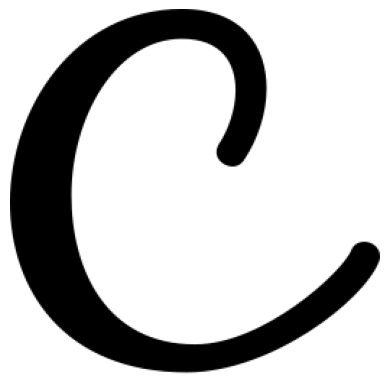

In [5]:
#!g1.4
def save_sampled(x: np.ndarray, name):
    file = Path('imgs') / name
    file.parent.mkdir(parents=True, exist_ok=True)
    svg = SVG.decode(x, path=file)
    svg.dump_to_file()

def show_sampled(x: np.ndarray, axis=None):
    if axis is None:
        axis = plt
    svg = SVG.decode(x)
    svg.mulsize(256)
    svg2png(bytestring=svg.dump(), write_to='imgs/tmp.png')
    img = mpimg.imread('imgs/tmp.png')
    axis.axis('off')
    axis.imshow(img)
    
imgs, labels, font_names = dataset_test[12*3]
print(labels[0], font_names[0], sep=', ')
save_sampled(imgs[0], 'test_print.svg')
show_sampled(imgs[0])

## Определение рисователя прогресса

In [6]:
#!g1.4
class Progresser:
    def __init__(self, _train_dataloader, split_num=4, xlabel='time (epochs)', ylabel='loss'):
        self.epoch = 0
        self.ox = {}
        self.oy = {}
        self.color = {}
        self.interval = len(_train_dataloader) // split_num
        self.xlabel = xlabel
        self.ylabel = ylabel

    def show_progress(self, t, epochs, save_to=None, info: Optional[dict] = None, clear=True):
        if clear:
            display.clear_output(wait=True)
        fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12, 10))
        fig.suptitle(f'Epoch {t:3.3f} / {epochs}', fontsize=16)

        for ax, msg in zip(axs, ('', 'last 50%')):
            title = f'loss {msg}'
            if info is not None:
                title += ' | ' + ' | '.join(f'{key}: {value}' for key, value in info.items())
            ax.set_title(title)
            ax.set_xlabel('time (epochs)')
            ax.set_ylabel('loss')

        for label in self.oy.keys():
            ox, oy, c = self.ox[label], self.oy[label], self.color[label]
            last = str(oy[-1]) if len(oy) > 0 else ''
            axs[0].plot(ox, oy, c=c, lw=3, label=f'{label}: {last}')
            axs[1].plot(
                ox[- len(ox) // 2:], oy[- len(oy) // 2:], 
                c=c, lw=3, label=f'{label}: {last}'
            )

        axs[0].legend()
        axs[1].legend()
        if save_to is None:
            plt.show() 
        else:
            if not isinstance(save_to, Path):
                save_to = Path(save_to)
            save_to.parent.mkdir(exist_ok=True, parents=True)
            plt.savefig(str(save_to))
            plt.close()
        plt.close()
    
    def add_train(self, ts, loss):
        self.add(ts, loss, 'train', 'darkblue')

    def add_test(self, ts, loss):
        self.add(ts, loss, 'test', 'green')
        
    def add(self, x, y, label, color=None):
        self.color[label] = color
        self.ox.setdefault(label, []).append(x)
        self.oy.setdefault(label, []).append(y)
        
    def reset(self):
        self.ox = {}
        self.oy = {}
        self.epoch = 0

## Дискриминатор

In [7]:
#!g1.4
class Block(nn.Module):
    def __init__(self, f_in, f_out, activation=nn.SiLU):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(f_in, f_out),
            activation(),
        )

    def forward(self, x):
        return self.layer(x)

    
class Discriminator(nn.Module):
    """0 for real, 1 for generated"""
    def __init__(self, params):
        super().__init__()
        assert params[-1] == 1
        self.name = f'{self.__class__.__name__}_{params}'
        
        self.layers = nn.Sequential(
            *[Block(params[i], params[i + 1]) for i in range(len(params) - 2)],
            Block(params[-2], params[-1], activation=nn.Sigmoid),
        )
        self._loss_fn = nn.BCELoss(reduction='mean')
    
    def forward(self, x):
        segments = [
            x[:, 0:8],
            x[:, 4:12],
            x[:, 8:16],
            x[:, 12:20],
            x[:, 16:24],
            x[:, 20:28],
            x[:, 24:32],
            torch.cat((x[:, 28:32], x[:, 0:4]), 1),
        ]
        segments = [
            self.layers(s.view(s.shape[0], -1))
            for s in segments
        ]
        stacked = torch.stack(segments)
        return torch.mean(stacked, dim=0)

    def loss(self, x_hat, x):
        return self._loss_fn(x_hat, x)
    
    def mysave(self):
        save_folder = Path('models') / self.__class__.__name__ / self.name
        save_folder.mkdir(parents=True, exist_ok=True)
        torch.save(self.state_dict(), save_folder / 'ckpt.pt')

    def myload(self):
        path = Path('models') / self.__class__.__name__ / self.name / 'ckpt.pt'
        if path.exists():
            self.load_state_dict(torch.load(path))
            return True
        return False
    
    def step(self, x_real, x_fake, d_optim, update=True):
        real_and_fake_input = torch.cat((x_real, x_fake))
        d_labels_real = torch.zeros(len(x_real), 1).to(device)
        d_labels_fake = torch.ones(len(x_fake), 1).to(device)
        d_out = self(real_and_fake_input)
        d_out_real = d_out[:len(d_out) // 2]
        d_out_fake = d_out[len(d_out) // 2:]
        d_loss_real = self.loss(d_out_real, d_labels_real)
        d_loss_fake = self.loss(d_out_fake, d_labels_fake)
        d_loss = (d_loss_real + d_loss_fake) / 2
        if update:
            d_optim.zero_grad()
            d_loss.backward()
            d_optim.step()
        return d_loss, d_loss_fake, d_loss_real, d_out
    
    def make_some_noise(self, images):
        noise_pattern = images[:, :, SVG.ONE_HOT_LEN:]
        zeros = noise_pattern == 0.
        a = torch.full([noise_pattern.shape[0], 1, 1], 1e-5)
        b = torch.full([noise_pattern.shape[0], 1, 1], 1e-1)
        std = torch.distributions.Uniform(a, b).sample().to(device)
        std = std.repeat(1, noise_pattern.shape[1], noise_pattern.shape[2])
        std[zeros] = 0.
        noised = torch.normal(mean=noise_pattern, std=std)

        fake_images = images.clone()
        fake_images[:, :, SVG.ONE_HOT_LEN:] = noised
        return fake_images
    
    def train_fn(self, epoch, epochs, dataloader, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, (images, _, font_names) in enumerate(dataloader):
            # bs x ? x 32 x 11
            images = np.concatenate(images)
            # BS x 32 x 11
            images = torch.Tensor(images).to(device)
            fake_images = self.make_some_noise(images)
            
            loss, loss_fake, loss_real, out = self.step(images, fake_images, optimizer)
            out_round = torch.round(out)
            half = len(out_round) // 2
            out_round[:half] = 1 - out_round[:half]
            accuracy = torch.mean(out_round)

            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                progresser.add(t, 1 - accuracy.detach().cpu().numpy(), 'error_rate', 'red')
                progresser.add(t, loss_fake.item(), 'discr_fake', 'orange')
                progresser.add(t, loss_real.item(), 'discr_real', 'yellow')
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, show=True):
        self.eval()
        tmp_test_loss = []
        for images, _, _ in dataloader:
            images = np.concatenate(images)
            images = torch.Tensor(images).to(device)
            fake_images = self.make_some_noise(images)
            loss, loss_fake, loss_real, out = self.step(images, fake_images, None, update=False)
            
            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            progresser.show_progress(epoch, epochs)
        
    def optimize(self, x, steps=100, lr=3e-4):
        x.requires_grad = True
        
        optimizer = optim.Adam((x,), lr=lr)
        for _ in tqdm(range(steps)):
            out = self(x).mean()
            optimizer.zero_grad()
            out.backward()
            optimizer.step()
        return x

## Автоэнкодер

In [8]:
#!g1.4
class AE(nn.Module):
    activation = nn.Tanh

    def __init__(self, params, line_size, discriminator=None, d_optim=None):
        super().__init__()
        self.name = f'{self.__class__.__name__}_{params}'

        self.line_size = line_size
        
        encoder_params = params[:]
        encoder_params[-1] *= 2
        decoder_params = params[::-1]

        self.encoder = []
        for i in range(len(encoder_params) - 2):
            self.encoder.append(Block(encoder_params[i], encoder_params[i + 1], activation=nn.Tanh))
        self.encoder.append(Block(encoder_params[-2], encoder_params[-1], activation=nn.Tanh))
        self.encoder.append(nn.Linear(encoder_params[-1], encoder_params[-1]))

        self.decoder = []
        for i in range(len(decoder_params) - 2):
            self.decoder.append(Block(decoder_params[i], decoder_params[i + 1], activation=nn.Tanh))
        self.decoder.append(Block(decoder_params[-2], decoder_params[-1], activation=nn.ReLU))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        # idk how to extract field from module submodules
        self.discriminator = [discriminator, d_optim]
        self.last_d_loss = 1
        self.generator = torch.Generator(device=device)
        
    def encode(self, x):
        x = x.view(x.shape[0], -1)
        moments = self.encoder(x)
        moments = moments.view(x.shape[0], -1, 1, 1)
        return DiagonalGaussianDistribution(moments)

    def decode(self, z):
        z = self.decoder(z)
        z = z.view(z.shape[0], -1, self.line_size)
        return z
    
    def forward(self, x, sample_posterior=False):
        posterior = self.encode(x)
        if sample_posterior:
            z = posterior.sample(generator=self.generator)
        else:
            z = posterior.mode()
        z = z.view(z.shape[0], z.shape[1])
        return self.decode(z)
        
    def loss(self, x_hat, x):
        mse1 = F.mse_loss(x_hat[:, :SVG.ONE_HOT_LEN], x[:, :SVG.ONE_HOT_LEN], reduction='sum') / SVG.ONE_HOT_LEN
        mse2 = F.mse_loss(x_hat[:, SVG.ONE_HOT_LEN:], x[:, SVG.ONE_HOT_LEN:], reduction='sum')
        return (mse1 + mse2) / x.shape[0]

    def train_fn(self, epoch, epochs, dataloader, optimizer, scheduler, pbar=None, show=True):
        discriminator, d_optim = self.discriminator
        self.train()
        num_batches = len(dataloader)
        for batch, (images, _, font_names) in enumerate(dataloader):
            # bs x ? x 32 x 11
            images = np.concatenate(images)
            images = torch.Tensor(images).to(device)
               
            posterior = self.encode(images)

            kl_loss = posterior.kl().mean() * 1e-4
            z = posterior.sample(generator=self.generator)
            z = z.view(z.shape[0], z.shape[1])
            output = self.decode(z)

            mse_loss = self.loss(output, images)
            loss = mse_loss + kl_loss
            
            d_out_ae = discriminator(output).mean() * max((0.7 - self.last_d_loss / 2), 0) * mse_loss.item()
            loss = loss + d_out_ae

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Обучение дискриминатора на тех же данных
            # d_loss, d_loss_fake, d_loss_real, _ = discriminator.step(images, output.detach(), d_optim)
            
            # self.last_d_loss = d_loss.item()
            
            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add(t, mse_loss.item(), 'mse', 'purple')
                progresser.add(t, kl_loss.item(), 'kl_loss', 'deepskyblue')
                progresser.add(t, to_numpy(d_out_ae), 'discriminator', 'orange')
                progresser.add_train(t, loss.item())
                if show:
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()            
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, show=True):
        self.eval()
        discriminator, _ = self.discriminator
        
        tmp_test_loss = []
        d_tmp_test_loss = []
        for images, _, _ in dataloader:
            images = np.concatenate(images)
            images = torch.Tensor(images).to(device)
            
            output = self(images)
            loss = self.loss(output, images)
            
            d_loss, _, _, _ = discriminator.step(images, output.detach(), None, update=False)

            tmp_test_loss.append(loss.item())
            d_tmp_test_loss.append(d_loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        progresser.add(epoch, np.mean(d_tmp_test_loss), 'test_d_loss', 'pink')
        if show:
            progresser.show_progress(epoch, epochs)
            
    def mysave(self):
        save_folder = Path('models') / self.__class__.__name__ / self.name
        save_folder.mkdir(parents=True, exist_ok=True)
        torch.save(self.state_dict(), save_folder / 'ckpt.pt')
        self.discriminator[0].mysave()

    def myload(self):
        path = Path('models') / self.__class__.__name__ / self.name / 'ckpt.pt'
        if path.exists():
            self.load_state_dict(torch.load(path))
            return True
        return False

## Вспомогательные функции

In [9]:
#!g1.4
def to_numpy(d):
    return d.cpu().detach().numpy()


ONE_HOT_LEN = FONT_SIZE
one_hot_rules = {
    glyph: one_hot
    for glyph, one_hot in zip(
        dl.GLYPH_FILTER,
        range(0, ONE_HOT_LEN),
    )
}


def labels2num(labels):
    return torch.Tensor([one_hot_rules[i] for i in labels]).long()


def labels2one_hot(labels):
    return F.one_hot(labels2num(labels), num_classes=ONE_HOT_LEN)


def run(model, train_dl, test_dl, optimizer, scheduler, epochs, params, _epoch=0, trial=None, save=True):
    class_name = model.__class__.__name__

    save_folder = Path('models') / model.__class__.__name__ / model.name
    loss_img_path = str(save_folder / '_loss.png') if save else None
    save_folder.mkdir(parents=True, exist_ok=True)
    
    plt.clf()
    max_epoch = progresser.epoch + epochs

    if trial is None:
        pbar = trange(progresser.epoch, max_epoch)
        rng = pbar
    else:
        pbar = None
        rng = range(progresser.epoch, max_epoch)
    for _epoch in rng:
        model.train_fn(_epoch, max_epoch, train_dl, optimizer, scheduler, pbar, show=True)
        model.test_fn(_epoch + 1, max_epoch, test_dl, show=True)
        
        if save:
            model.mysave()
        if trial is not None:
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        else:
            progresser.epoch = _epoch + 1
        progresser.show_progress(_epoch + 1, max_epoch, loss_img_path, info={'params':params, 'lr': scheduler.get_last_lr()[0]})

def setup_ae(params, d_params, lr, weight_decay=2e-5, step_size=1, step_gamma=0.95, line_size=None):
    if line_size is None:
        raise Exception('line_size should be provided')

    discriminator = Discriminator(d_params).to(device)
    d_optim = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay)
    
    model = AE(params, line_size, discriminator, d_optim).to(device)
        
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=step_gamma)

    return model, optimizer, scheduler


## Поиск конфигурации модели для кодирования глифов

Запуск дашборда `optuna-dashboard --server wsgiref sqlite:///db_full.sqlite3`
http://127.0.0.1:8080/

In [ ]:
#!g1.4
def run_for_search(trial):
    lr = trial.suggest_float('lr', 7e-6, 8e-4, log=True)
    p0 = trial.suggest_int('p0', 1600, 4500)
    params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, p0]
    latent_size = 256

    for i in range(1, 5):
        params.append(trial.suggest_int(f'p{i}', latent_size, params[-1]))
    params.append(latent_size)
    # step_gamma = trial.suggest_float('step_gamma', 0.94, 1)
    
    model, optimizer, scheduler = setup_ae(
        params=params,
        lr=lr,
        weight_decay=3e-6,
        line_size=SVG.ENCODE_WIDTH,
        step_gamma=0.95,
    )
    run(
        model=model, 
        train_dl=train_dataloader,
        test_dl=test_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=15,
        params=params,
        run_name='temp',
        trial=trial,
    )
    return progresser.test_loss[-1]


study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///db_ae.sqlite3",
    study_name="ae_lr,6layers,15epoch",
    load_if_exists=True,
)

study.optimize(run_for_search, n_trials=14, show_progress_bar=True)

## Создание и запуск AE

AE had been loaded from file
Discriminator has been loaded from file


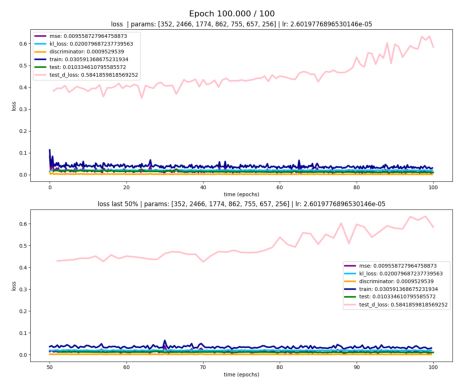

In [14]:
#!g1.4
force = False
GLIPH_WIDTH = 256
params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, 2466, 1774, 862, 755, 657, GLIPH_WIDTH]
d_params = [8 * SVG.ENCODE_WIDTH, 512, 256, 128, 64, 32, 16, 8, 4, 1]
# lr = 2e-3
# lr = 1e-3
lr = 6e-5

model_ae, optimizer, scheduler = setup_ae(
    params=params,
    d_params=d_params,
    lr=lr,
    weight_decay=4e-6,
    line_size=SVG.ENCODE_WIDTH,
    step_size=3,
    step_gamma=0.975,
)
if not force and model_ae.myload():
    print('AE had been loaded from file')
    save_folder = Path('models') / model_ae.__class__.__name__ / model_ae.name
    img = mpimg.imread(Path(save_folder) / '_loss.png')
    plt.axis('off')
    plt.imshow(img)
else:
    print('Created new AE')
if not force and model_ae.discriminator[0].myload():
    print('Discriminator has been loaded from file')
else:
    print('Created new Discriminator')

In [24]:
progresser = Progresser(train_dataloader)

In [42]:
#!g1.4
d_model, d_optimizer = model_ae.discriminator
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=3, gamma=0.975)
run(
    model=d_model,
    train_dl=train_dataloader,
    test_dl=test_dataloader,
    optimizer=d_optimizer,
    scheduler=d_scheduler,
    epochs=20,
    params=d_params,
)
d_progresser = progresser

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:52:57<00:00, 518.86s/it]


In [45]:
#!g1.4
progresser = Progresser(train_dataloader)

In [46]:
#!g1.4
run(
    model=model_ae,
    train_dl=train_dataloader,
    test_dl=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=100,
    params=params,
)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:39:42<00:00, 59.82s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 68.80it/s]
C:\Users\flydz\AppData\Local\Temp\ipykernel_6276\1300024226.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, imgs_num, i + 1)


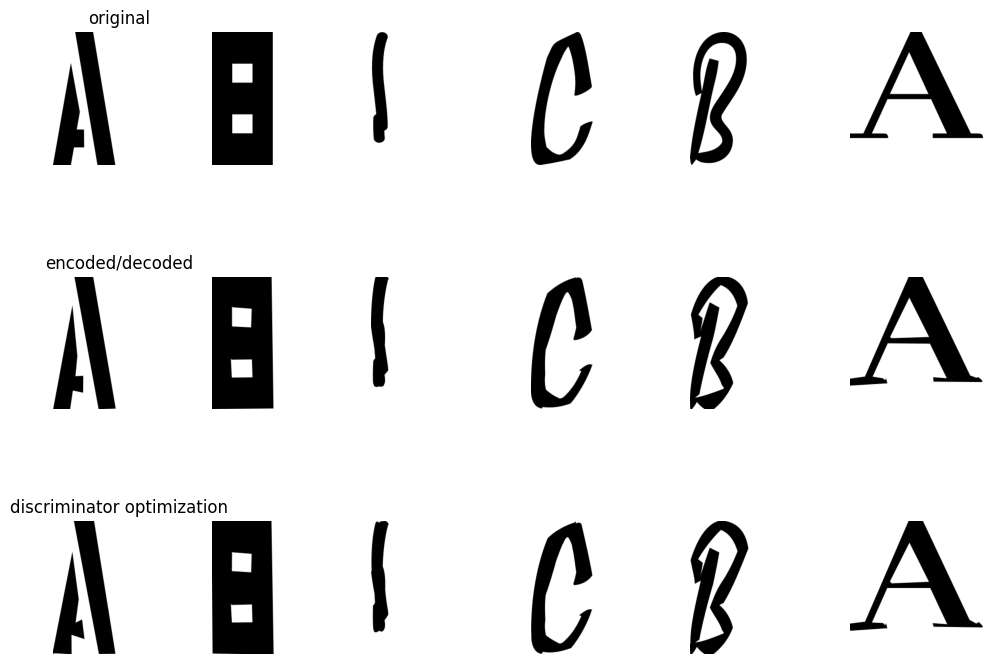

In [47]:
#!g1.4
imgs_num = 6
plt.figure(figsize=(2 * imgs_num, 9))
plt.axis('off')

pre_samples, _, _ = dataset_train[:(100)*imgs_num: 100]

samples = []
for font in pre_samples:
    samples.append(font[0].reshape(1, SVG.ENCODE_HEIGHT, SVG.ENCODE_WIDTH))
samples = np.concatenate(samples)
    
model_ae.eval()
processed_samples = to_numpy(model_ae(torch.Tensor(samples).to(device)))

refined_samples = to_numpy(
    model_ae.discriminator[0].optimize(
        torch.Tensor(processed_samples).to(device),
        steps=300,
        lr=2e-5,
    )
)

for i in range(imgs_num):
    plt.subplot(3, imgs_num, i + 1)
    plt.axis('off')
    if i == 0:
        plt.title('original')
    show_sampled(samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, imgs_num + i + 1)
    plt.axis('off')
    if i == 0:
        plt.title('encoded/decoded')
    show_sampled(processed_samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, imgs_num * 2 + i + 1)
    plt.axis('off')
    if i == 0:
        plt.title('discriminator optimization')
    show_sampled(refined_samples[i])
plt.show()

In [15]:
#!g1.4
def decode_img(d):
    model_ae.eval()
    with torch.no_grad():
        return model_ae.decode(d)

def encode_img(d):
    model_ae.eval()
    with torch.no_grad():
        posterior = model_ae.encode(d)
        z = posterior.mode()
        z = z.view(z.shape[0], z.shape[1])
        return z

mse 2.4357426


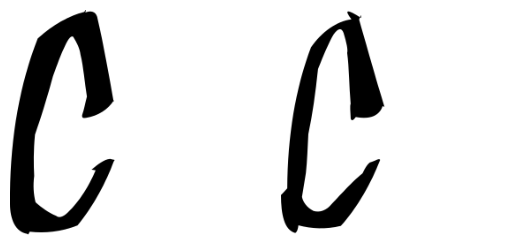

In [16]:
#!g1.4
sample = dataset_train[100 * 3][0][0]

sample = torch.Tensor(sample.reshape((1, -1))).to(device)

sp = encode_img(sample)

plt.subplot(1, 2, 1)
plt.axis('off')
show_sampled(to_numpy(decode_img(sp)[0]))

shift = torch.randn_like(sp) * 0.1
print('mse', shift.pow(2).sum().cpu().numpy())

sp += shift

plt.subplot(1, 2, 2)
sp_decoded = decode_img(sp)
show_sampled(to_numpy(sp_decoded[0]))

plt.show()

In [17]:
from ipywidgets import interact

In [18]:
img = dataset_test[81][0][0]

@interact(x=(-1,1,0.01), s=(0, 255))
def f(x=0, s=0):
    tmp = encode_img(torch.Tensor([img]).to(device))
    tmp[0][s] = x
    decoded = decode_img(tmp)
    show_sampled(to_numpy(decoded)[0])


interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), IntSlider(value=0…

## Дифузионная модель

In [135]:
%pip install --upgrade diffusers transformers accelerate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [52]:
import diffusers
from diffusers import UNet2DModel
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers import DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.utils import randn_tensor
from diffusers.schedulers.scheduling_ddpm import DDPMSchedulerOutput

In [60]:
#!g1.4
IMG_SIZE = 16
EPOCHS = 500

dataset = ConcatDataset([dataset_train, dataset_test])
dataloader = DataLoader(dataset, batch_size=6, shuffle=True, num_workers=0, collate_fn=dl.collate_fn)

In [61]:
#!g1.4
name = '64,128,256_2_mse'
try:
    model = UNet2DModel.from_pretrained(f'models/DiffusionCond/{name}/unet')
    print('Loaded from pretrained')
except Exception as e:
    print(e)
    model = UNet2DModel(
        sample_size=IMG_SIZE,  # the target image resolution
        in_channels=1,  # the number of input channels, 3 for RGB images
        out_channels=1,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(64, 128, 256),  # the number of output channes for each UNet block
        down_block_types=(
            "DownBlock2D",
            "AttnDownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",
            "AttnUpBlock2D",
            "UpBlock2D",
        ),
        num_class_embeds=FONT_SIZE,
        class_embed_type='timestep',
    )
model.to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Loaded from pretrained
Num params:  14818177


UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (class_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, 

In [62]:
class MyDDPMScheduler(DDPMScheduler):
    def mystep(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        generator=None,
        return_dict: bool = True,
    ):
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.FloatTensor`): direct output from learned diffusion model.
            timestep (`int`): current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                current instance of sample being created by diffusion process.
            generator: random number generator.
            return_dict (`bool`): option for returning tuple rather than DDPMSchedulerOutput class

        Returns:
            [`~schedulers.scheduling_utils.DDPMSchedulerOutput`] or `tuple`:
            [`~schedulers.scheduling_utils.DDPMSchedulerOutput`] if `return_dict` is True, otherwise a `tuple`. When
            returning a tuple, the first element is the sample tensor.

        """
        t = timestep
        num_inference_steps = self.num_inference_steps if self.num_inference_steps else self.config.num_train_timesteps
        prev_t = timestep - self.config.num_train_timesteps // num_inference_steps

        if model_output.shape[1] == sample.shape[1] * 2 and self.variance_type in ["learned", "learned_range"]:
            model_output, predicted_variance = torch.split(model_output, sample.shape[1], dim=1)
        else:
            predicted_variance = None

        # 1. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        # 2. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
        if self.config.prediction_type == "epsilon":
            pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
        elif self.config.prediction_type == "sample":
            pred_original_sample = model_output
        elif self.config.prediction_type == "v_prediction":
            pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
        else:
            raise ValueError(
                f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample` or"
                " `v_prediction`  for the DDPMScheduler."
            )

        # 3. Clip "predicted x_0"
        if self.config.clip_sample:
            pred_original_sample = torch.clamp(
                pred_original_sample, -self.config.clip_sample_range, self.config.clip_sample_range
            )

        # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

        # 5. Compute predicted previous sample µ_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample

        # 6. Add noise
        variance = 0
        if t > 0:
            device = model_output.device
            variance_noise = randn_tensor(
                [1, *model_output.shape[1:]], generator=generator, device=device, dtype=model_output.dtype
            )
            variance_noise = variance_noise.repeat(model_output.shape[0], *[1 for _ in range(len(model_output.shape) - 1)])
            if self.variance_type == "fixed_small_log":
                variance = self._get_variance(t, predicted_variance=predicted_variance) * variance_noise
            elif self.variance_type == "learned_range":
                variance = self._get_variance(t, predicted_variance=predicted_variance)
                variance = torch.exp(0.5 * variance) * variance_noise
            else:
                variance = (self._get_variance(t, predicted_variance=predicted_variance) ** 0.5) * variance_noise

        pred_prev_sample = pred_prev_sample + variance

        if not return_dict:
            return (pred_prev_sample,)

        return DDPMSchedulerOutput(prev_sample=pred_prev_sample, pred_original_sample=pred_original_sample)

In [63]:
#!g1.4
def make_grid(images, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    axes = axes.flatten()
    
    images = to_numpy(decode_img(images.reshape((-1, GLIPH_WIDTH))))
    for i, image in enumerate(images):
        show_sampled(image, axes[i])
    return fig, axes

def evaluate(epoch):
    torch.manual_seed(12)
    imgs = torch.randn((4, 1, IMG_SIZE, IMG_SIZE), device=device)
    labels = labels2num(['one', 'y', 'z', 'N']).to(device)
    for t in tqdm(itertools.chain(noise_scheduler.timesteps, noise_scheduler.timesteps[700:]), total=1300, leave=True, position=0):
        with torch.no_grad():
            residual = model(imgs, t, labels).sample

        imgs = noise_scheduler.step(residual, t, imgs).prev_sample
    
    fig, axes = make_grid(imgs, rows=2, cols=2)

    # Save the images
    test_dir = Path(f'imgs/DiffusionCond/{name}')
    test_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(test_dir / f'{epoch:04d}.png')
    plt.close(fig)

In [64]:
#!g1.4
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(dataloader) * EPOCHS),
)
num_train_timesteps=1000
progresser = Progresser(dataloader)
try:
    noise_scheduler = MyDDPMScheduler.from_pretrained(f'models/DiffusionCond/{name}/scheduler')
    print('Noise sheduler loaded from pretrained')
except Exception as e:
    print(e)
    noise_scheduler = MyDDPMScheduler(num_train_timesteps=num_train_timesteps)

Noise sheduler loaded from pretrained


In [65]:
def loss_fn(x_hat, x):
    mse = F.mse_loss(x_hat, x, reduction='sum')
    return mse / x.shape[0]

In [66]:
#!g1.4
global_step = 0

In [67]:
#!g1.4
for epoch in range(progresser.epoch, progresser.epoch + EPOCHS):
    progress_bar = tqdm(total=len(dataloader), position=0, leave=True)
    progress_bar.set_description(f"Epoch {epoch}")

    for step, (font_svgs, font_labels, font_names) in enumerate(dataloader):
        fonts_num = len(font_names)
        
        svgs_tensor = torch.Tensor(np.concatenate(font_svgs)).to(device)
        
        clean_images = encode_img(svgs_tensor).reshape((-1, 1, IMG_SIZE, IMG_SIZE))
        
        # Генерируем одинаковые параметры шума и шага для образцов внутри одного шрифта
        noise_per_font = [
            torch.randn((len(font_name), 1, IMG_SIZE, IMG_SIZE)).to(device)
            for font_name in font_names
        ]
        noise = torch.cat(noise_per_font)
        
        timesteps_per_font = [
            torch.randint(0, num_train_timesteps, (len(font_name),), device=device).long()
            for font_name in font_names
        ]
        timesteps = torch.cat(timesteps_per_font)
        
        # forward diffusion process
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Predict the noise residual
        labels = labels2num(np.concatenate(font_labels)).to(device)
        
        noise_pred = model(noisy_images, timesteps, labels, return_dict=False)[0]
        loss = loss_fn(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        progress_bar.set_postfix(**logs)
        global_step += 1
        
        if step % 100 == 0 or step + 1 == len(dataloader):
            progresser.add_train(epoch + step / len(dataloader), loss.detach().item())
    progresser.show_progress(epoch, progresser.epoch + EPOCHS, save_to=f'imgs/DiffusionCond/_{name}.loss.png', clear=False)
    pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
    evaluate(epoch)
    pipeline.save_pretrained(f'models/DiffusionCond/{name}')
    torch.save(model.state_dict(), f'models/DiffusionCond/{name}/ckpt.pt')

Epoch 49:  23%|███████▎                       | 1399/5972 [03:19<10:04,  7.57it/s, loss=5.28, lr=0.000195, step=294026]

In [68]:
#!g1.4
evaluate(999)

100%|██████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:40<00:00, 32.02it/s]


## Визуализация генерации

In [69]:
#!g1.4
def sample(n=1, imgs=None, labels=None, timestemps=None):
    if imgs is None:
        imgs = torch.randn((n, 1, IMG_SIZE, IMG_SIZE), device=device)
    if labels is None:
        labels = labels or np.random.choice(dl.GLYPH_FILTER, n)
    labels_num = labels2num(labels).to(device)
    
    timestemps = timestemps or [300]
    
    noise_scheduler.set_timesteps(timestemps[0])
    
    ts = noise_scheduler.timesteps
    for t in tqdm(itertools.chain(*[ts[len(ts) - tsr:] for tsr in timestemps]), position=0, leave=True, total=sum(timestemps)):
        with torch.no_grad():
            residual = model(imgs, t, labels_num).sample

        imgs = noise_scheduler.mystep(residual, t, imgs).prev_sample
    return imgs, labels

def smart_sample(n=1, imgs=None, labels=None):
    r_samples = []
    r_discrs = []
    timestemps = [
        [300],
        [500],
        [300, 30],
        [500, 100, 10],
        [1000],
        [1000, 200],
    ]
    for ts_rep in timestemps:
        samples, labels = sample(n, imgs, labels, timestemps=ts_rep)
        with torch.no_grad():
            svg = decode_img(imgs.reshape(-1, IMG_SIZE*IMG_SIZE))
            discrs = model_ae.discriminator[0](svg.clone())
        r_samples.append(samples)
        r_discrs.append(discrs)
    r_samples = torch.cat(r_samples, 1)
    r_discrs = torch.stack(r_discrs).reshape(-1, n)
    min_ind = r_discrs.min(0).indices
    rngs = np.arange(n)
    res = r_samples[rngs, min_ind].reshape(n, 1, IMG_SIZE, IMG_SIZE)
    return res, labels

def sample_img(n=1, imgs=None, labels=None, timestemps=[300]):
    imgs, labels = sample(n, imgs, labels, timestemps=timestemps)
    svgs = to_numpy(decode_img(imgs.reshape(-1, IMG_SIZE*IMG_SIZE)))
    return svgs, labels

def smart_sample_img(n=1, imgs=None, labels=None):
    imgs, labels = smart_sample(n, imgs, labels)
    svgs = to_numpy(decode_img(imgs.reshape(-1, IMG_SIZE*IMG_SIZE)))
    return svgs, labels

100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:24<00:00, 44.72it/s]


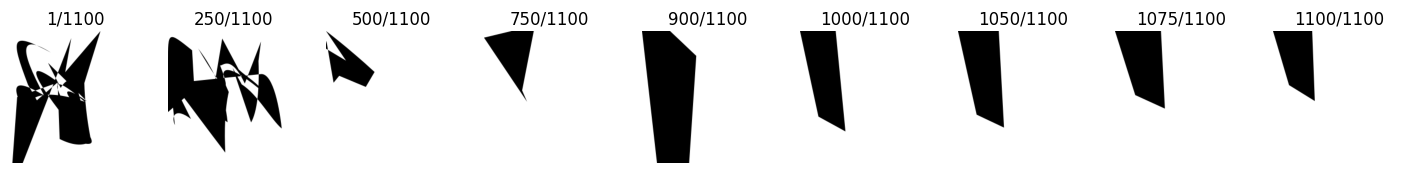

In [120]:
def show_sampling_progress():
    n = 1
    imgs = torch.randn((n, 1, IMG_SIZE, IMG_SIZE), device=device)
    labels = np.random.choice(dl.GLYPH_FILTER, n)
    labels_num = labels2num(labels).to(device)
    discriminator = model_ae.discriminator[0]
    
    result = [[] for i in range(n)]
    discr_values = [[] for i in range(n)]
    
    show_steps = [1, 250, 500, 750, 900, 1000, 1050, 1075, 1100]
    ts = noise_scheduler.timesteps
    timestemps = [1000, 100]
    
    for i, t in enumerate(tqdm(itertools.chain(*[ts[len(ts) - tsr:] for tsr in timestemps]), position=0, leave=True, total=sum(timestemps))):
        with torch.no_grad():
            residual = model(imgs, t, labels_num).sample
        imgs = noise_scheduler.step(residual, t, imgs).prev_sample
        if i + 1 in show_steps:
            _imgs = to_numpy(decode_img(imgs.reshape(-1, IMG_SIZE*IMG_SIZE)))
            discrs = to_numpy(discriminator(torch.Tensor(_imgs).to(device)))

            for j, img in enumerate(_imgs):
                result[j].append(img)
                discr_values[j].append(discrs[j])
    for i, row in enumerate(result):
        fig, axes = plt.subplots(1, len(row), figsize=(2*len(row), 2))
        
        for j, svg in enumerate(row):
            show_sampled(svg, axes[j])
            axes[j].title.set_text(f'{show_steps[j]}/{sum(timestemps)}')
        plt.show()
        plt.close(fig)

show_sampling_progress()

## Генерация шрифта

In [ ]:
def gen_font(z=None, show=True):
    n = FONT_SIZE
    if z is None:
        z = torch.randn((1, 1, IMG_SIZE, IMG_SIZE), device=device).repeat(n, 1, 1, 1)
    labels = dl.GLYPH_FILTER
    imgs, _ = sample_img(n, z, labels, timestemps=[800, 100])
    
    if show:  
        c_num = 7
        fig, axes = plt.subplots(
            math.ceil(n / c_num), c_num, 
            figsize=(math.ceil(n / c_num * 1.7), c_num * 5 // 2)
        )
        axes = axes.flatten()

        for j, (svg, label) in enumerate(zip(imgs, labels)):
            show_sampled(svg, axes[j])
            axes[j].title.set_text(label)
        plt.show()
        plt.close(fig)
    return imgs, labels
    
_ = gen_font()

## Сбор сэмплов

In [122]:
os.mkdir('imgs/my_png')
os.mkdir('imgs/my_svg')
for i in range(100):
    imgs, labels = gen_font(show=False)
    os.mkdir(f'imgs/my_png/{i}')
    os.mkdir(f'imgs/my_svg/{i}')
    for img, label in zip(imgs, labels):
        if label.isupper():
            label = '_' + label
        svg = SVG.decode(img)
        svg.mulsize(200)
        svg_xml = svg.dump()
        svg2png(bytestring=svg_xml, write_to=f'imgs/my_png/{i}/{label}.png')
        with open(f'imgs/my_svg/{i}/{label}.svg', 'w') as f:
            f.write(svg_xml)

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:31<00:00, 28.50it/s]


## Проверка распределения

In [123]:
#!g1.4
sampled, sampled_labels = sample(1000)
sampled_imgs = to_numpy(decode_img(sampled.reshape(-1, IMG_SIZE*IMG_SIZE)))
for i, (img, lbl) in enumerate(zip(sampled_imgs, sampled_labels)):
    svg = SVG.decode(img)
    svg.mulsize(256)
    out_path = Path(f'imgs/samples3/{lbl}_{i}.png')
    out_path.parent.mkdir(parents=True, exist_ok=True)
    svg2png(bytestring=svg.dump(), write_to=str(out_path))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:48<00:00,  6.21it/s]


In [130]:
#!g1.4
encoded_data = []
for images, _, _ in test_dataloader:
    images = encode_img(torch.Tensor(images[0]).to(device))
    encoded_data.append(images)

encoded_data = to_numpy(torch.cat(encoded_data, 0))
print("Data shape", encoded_data.shape)
tsne_model = TSNE()
embedding = tsne_model.fit_transform(encoded_data)


Data shape (7421, 256)


 25%|███████████████████▋                                                           | 249/1000 [00:20<01:02, 12.08it/s]

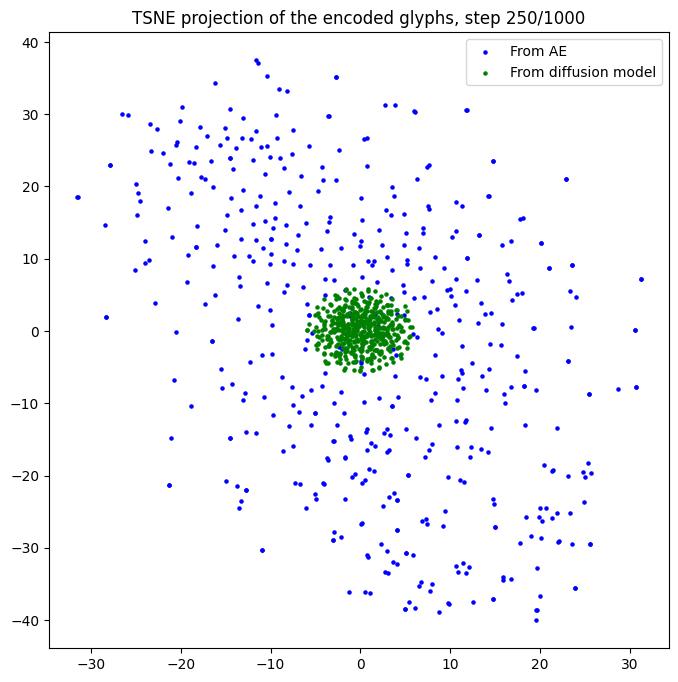

 50%|███████████████████████████████████████▎                                       | 498/1000 [00:48<00:43, 11.66it/s]

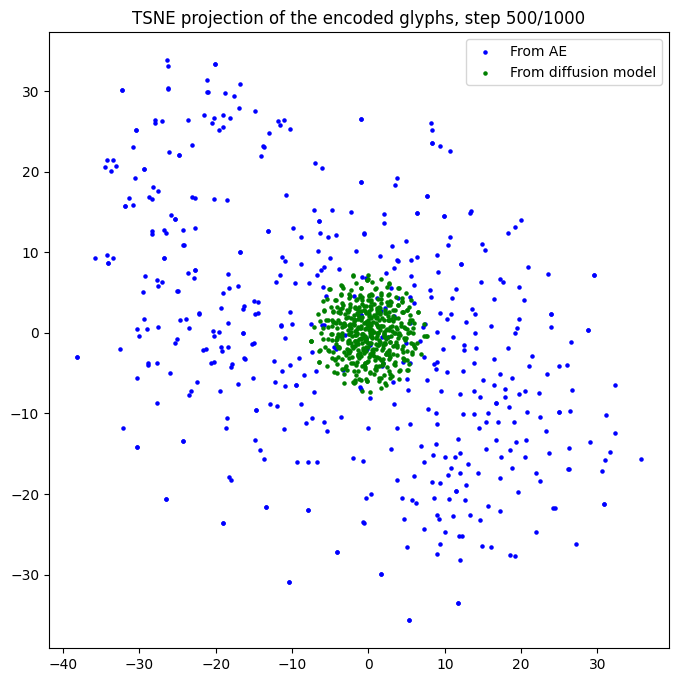

 75%|███████████████████████████████████████████████████████████                    | 748/1000 [01:18<00:21, 11.47it/s]

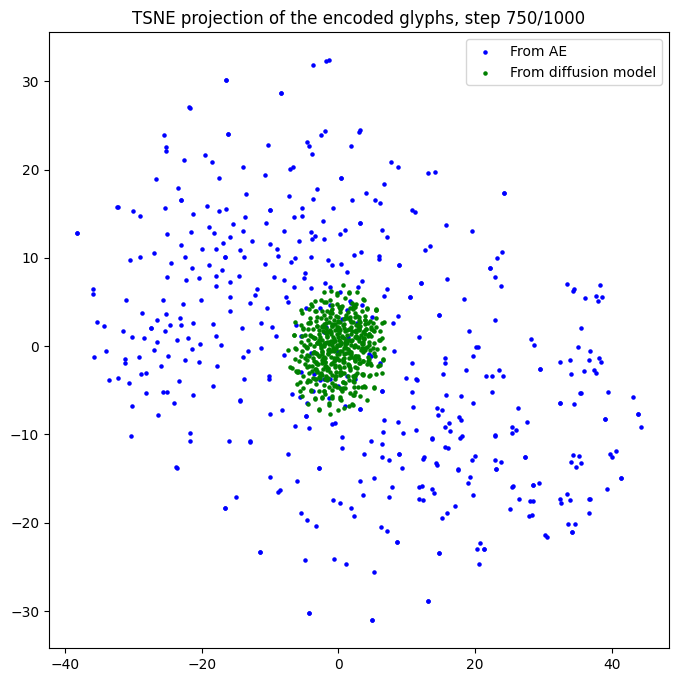

100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [01:47<00:00, 11.54it/s]

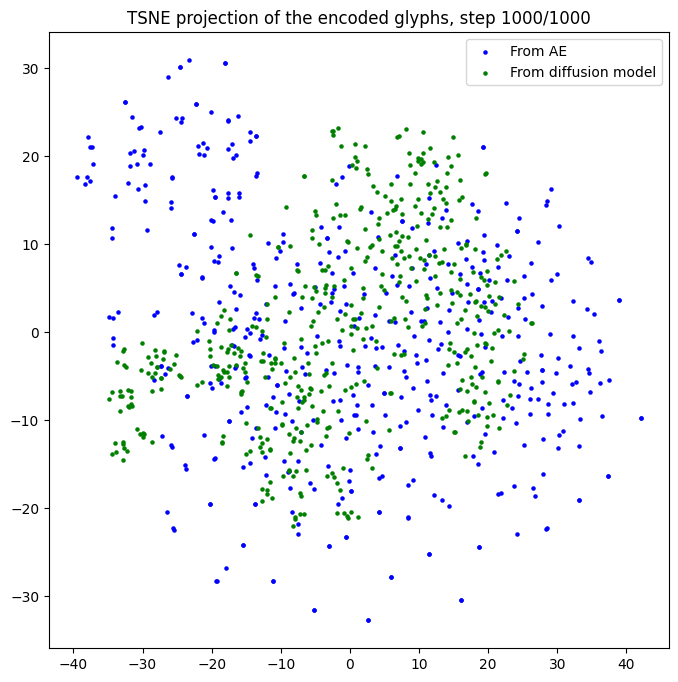

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.64it/s]


In [136]:
#!g1.4
imgs = torch.randn((500, 1, IMG_SIZE, IMG_SIZE), device=device)
labels = np.random.choice(dl.GLYPH_FILTER, 500)
labels = labels2num(labels).to(device)
noise_scheduler.set_timesteps(num_train_timesteps)
for i, t in enumerate(tqdm(noise_scheduler.timesteps, position=0, leave=True)):
    with torch.no_grad():
        residual = model(imgs, t, labels).sample

    imgs = noise_scheduler.step(residual, t, imgs).prev_sample
    if (i + 1) % 250 == 0:
        sampled_embedding = tsne_model.fit_transform(to_numpy(imgs.view((sampled.shape[0], -1))))
        orig_embedding = tsne_model.fit_transform(encoded_data[:500])
        
        plt.figure(figsize=(8, 8))

        plt.scatter(
            orig_embedding[:500, 0], orig_embedding[:500, 1], 
            c='b',
            s=5,
            label='From AE',
        )

        plt.scatter(
            sampled_embedding[:, 0], sampled_embedding[:, 1], 
            c='g',
            s=5,
            label='From diffusion model',
        )

        plt.legend()
        plt.title(f'TSNE projection of the encoded glyphs, step {i+1}/{num_train_timesteps}');
        plt.show()

In [140]:
#!g1.4
sampled, _ = sample(500, timestemps=[1000])
sampled_embedding = tsne_model.fit_transform(to_numpy(sampled.view((sampled.shape[0], -1))))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.89it/s]


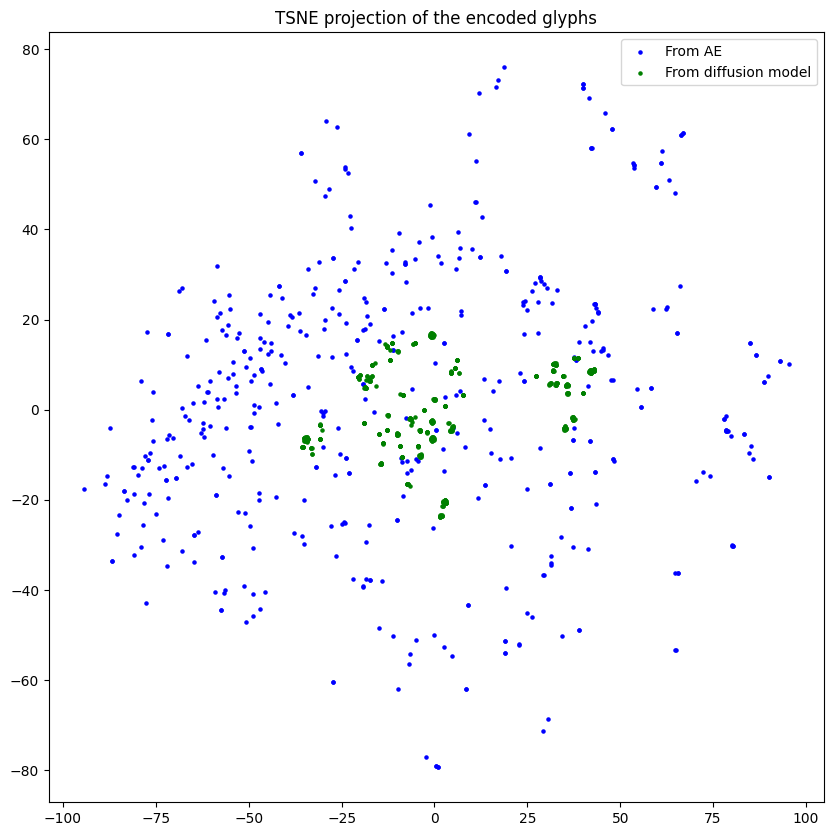

In [141]:
#!g1.4
plt.figure(figsize=(10, 10))


plt.scatter(
    embedding[:500, 0], embedding[:500, 1], 
    c='b',
    s=5,
    label='From AE',
)

plt.scatter(
    sampled_embedding[:, 0], sampled_embedding[:, 1], 
    c='g',
    s=5,
    label='From diffusion model',
)

plt.legend()
plt.title('TSNE projection of the encoded glyphs');
plt.show()